In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
end_date = session.query(measurement.date).order_by(measurement.date.desc()).limit(1).scalar()
# Get the date into datetime format 
end_date = datetime.strptime(end_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
delta = timedelta(days=365)
start_date = end_date - delta

print(start_date)
print(end_date)

2016-08-23 00:00:00
2017-08-23 00:00:00


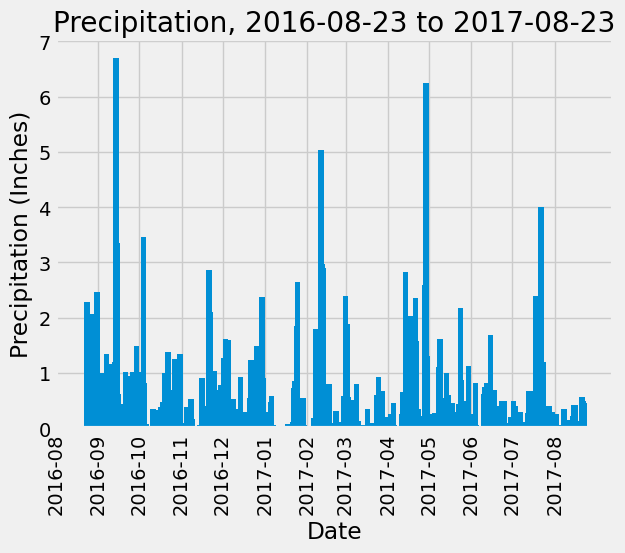

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 



# Perform a query to retrieve the data and precipitation scores
year_data = session.query(measurement.date,measurement.prcp).filter((func.strftime("%Y-%m-%d", measurement.date) >= start_date),(func.strftime("%Y-%m-%d", measurement.date) <= end_date)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_data_df = pd.DataFrame(year_data)

# Convert date column to datetime
year_data_df['date'] = pd.to_datetime(year_data_df['date'])

# Sort the dataframe by date
year_data_df = year_data_df.sort_values(by = 'date')



# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(year_data_df['date'], year_data_df['prcp'], width = 4)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
monthly_ticks = pd.date_range(start=start_date - pd.DateOffset(months=1), end=end_date, freq='MS')  # Extend end date to September
plt.xticks(monthly_ticks, monthly_ticks.strftime('%Y-%m'), rotation = 90) 
plt.title(f'Precipitation, {start_date.date()} to {end_date.date()}')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_data_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(func.distinct(measurement.station))).scalar()
station_count


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stations = []

station_activity = session.query(measurement.station,func.count(measurement.tobs).label('count')).group_by(measurement.station).order_by(desc('count'))

for station in station_activity:
    stations.append((station.station, station.count))
stations_df = pd.DataFrame(stations, columns = ['station', 'count'])


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_df['station'].iloc[0]

temperature_measurements = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station).one()

min_temp = temperature_measurements.min_temp
max_temp = temperature_measurements.max_temp
avg_temp = temperature_measurements.avg_temp

measurements_dict = {'min temp': min_temp, 
                     'max_temp': max_temp,
                     'avg_temp': round(avg_temp, 1)}
measurements_dict

{'min temp': 54.0, 'max_temp': 85.0, 'avg_temp': 71.7}

Text(0.5, 1.0, 'Histogram of Temperature Observations')

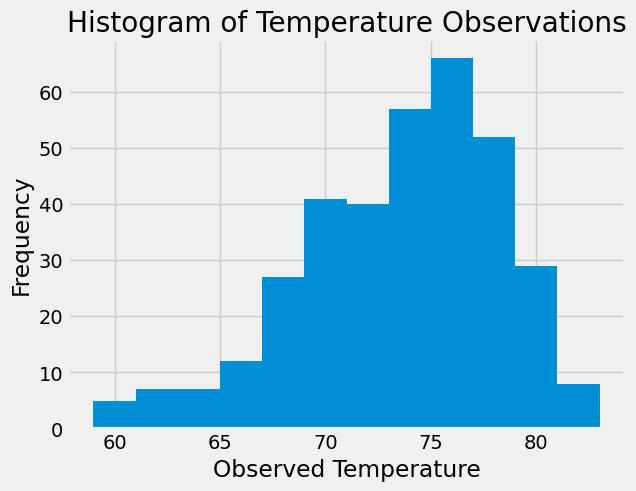

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_over_year = session.query(measurement.tobs).filter((measurement.station == most_active_station),(func.strftime("%Y-%m-%d", measurement.date) >= start_date), (func.strftime("%Y-%m-%d", measurement.date) <= end_date)).all()

# Convert query resutls to data frame
temp_over_year_df = pd.DataFrame(temp_over_year)

# Plot data
plt.hist(temp_over_year_df['tobs'], bins = 12)
plt.xlabel('Observed Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature Observations')

# Close Session

In [218]:
# Close Session
session.close()